## Import Libraries

In [75]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
#import pickle5 as pickle
import pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

from tabulate import tabulate  

## Import data and holdout data for prediction

In [20]:
df = pd.read_json('../../data/processed/encoded_labels/main_landscapes_all.json')
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'forest', 'tundra',
       'conserved_areas', 'freshwater', 'grassland', 'desert', 'marine',
       'wetlands', 'human_altered_areas', 'no tag', 'category_1', 'category_2',
       'category_3', 'labels'],
      dtype='object')

In [21]:
df_labels = df.drop(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'category_1', 'category_2', 'category_3',
       'labels'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,forest,120
1,tundra,3
2,conserved_areas,153
3,freshwater,58
4,grassland,48
5,desert,15
6,marine,85
7,wetlands,39
8,human_altered_areas,222
9,no tag,516


Text(0.5, 0, 'category')

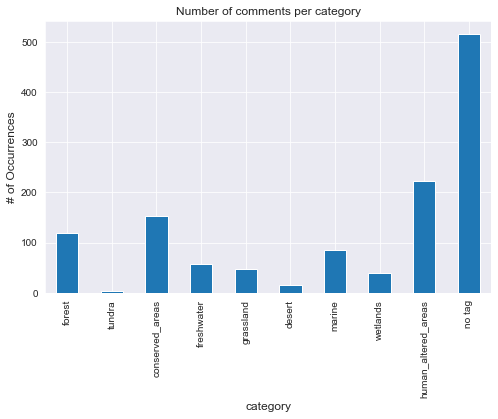

In [22]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

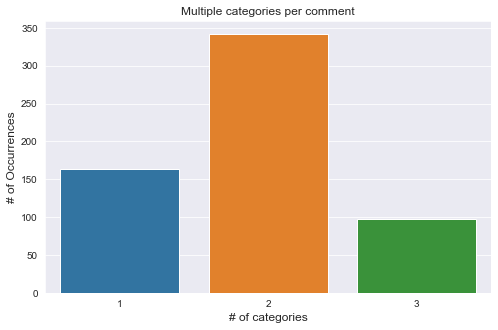

In [23]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## The distribution of the number of words in input texts

<AxesSubplot:>

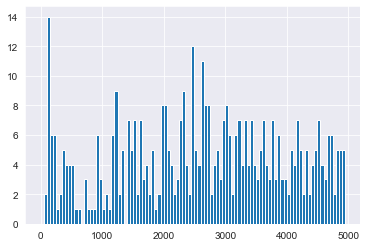

In [24]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [25]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [26]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'forest', 'tundra',
       'conserved_areas', 'freshwater', 'grassland', 'desert', 'marine',
       'wetlands', 'human_altered_areas', 'no tag', 'category_1', 'category_2',
       'category_3', 'labels'],
      dtype='object')

##  Features engineering

In [28]:
categories = [ 'forest', 'tundra',
       'conserved_areas', 'freshwater', 'grassland', 'desert', 'marine',
       'wetlands', 'human_altered_areas', 'no tag']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [74]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df
    
      
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    #dff[['accuracy_score', 'precision_score', 'recall_score', 'f1_score']] = dff[['accuracy_score', 'precision_score', 'recall_score', 'f1_score']].astype(float).round(3)
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#tabulate(lis, tablefmt='html')
header = lis[0].keys()
rows =  [x.values() for x in lis]



In [72]:
tabulate(rows, header, tablefmt='html')

Category,#Inputs,Classifiers,accuracy_score,precision_score,recall_score,f1_score
forest,120,Stochastic Gradient Descent Decsision Tree AdaBoost Gaussian Naive Bayes K Nearest Neighbor Random Forest,0.8055555555555556 0.8055555555555556 0.8222222222222222 0.7222222222222222 0.7944444444444444 0.8277777777777777,0.7319711538461539 0.7232142857142857 0.7625806451612904 0.6918160170447424 0.704045954045954 0.9088235294117647,0.7709247236357255 0.7193367257413581 0.6785400947534656 0.7685558869977189 0.6433584839445516 0.6219512195121951,0.7462848858281986 0.7212266029470331 0.7031539888682746 0.6875 0.6607406652743111 0.6459166190748143
tundra,3,Stochastic Gradient Descent Random Forest AdaBoost Gaussian Naive Bayes K Nearest Neighbor Decsision Tree,0.9944444444444445 0.9944444444444445 0.9944444444444445 0.9944444444444445 0.9944444444444445 0.9888888888888889,0.49722222222222223 0.49722222222222223 0.49722222222222223 0.49722222222222223 0.49722222222222223 0.4972067039106145,0.5 0.5 0.5 0.5 0.5 0.4972067039106145,0.4986072423398329 0.4986072423398329 0.4986072423398329 0.4986072423398329 0.4986072423398329 0.4972067039106145
conserved_areas,153,K Nearest Neighbor Stochastic Gradient Descent Gaussian Naive Bayes AdaBoost Decsision Tree Random Forest,0.85 0.8388888888888889 0.8277777777777777 0.8333333333333334 0.8222222222222222 0.8277777777777777,0.7962962962962963 0.7813846382409746 0.7738669238187078 0.7736742424242424 0.7593582887700534 0.7695035460992907,0.8008021390374331 0.8165106951871658 0.8322192513368984 0.7897727272727273 0.7593582887700534 0.7476604278074866,0.7984991085865916 0.795382384069617 0.7915966386554623 0.7809863724853991 0.7593582887700534 0.7572963333478318
freshwater,58,AdaBoost Stochastic Gradient Descent K Nearest Neighbor Decsision Tree Gaussian Naive Bayes Random Forest,0.9111111111111111 0.8944444444444445 0.8944444444444445 0.8722222222222222 0.6888888888888889 0.9,0.7976190476190477 0.7394715111478117 0.7394715111478117 0.6473975126669738 0.5917065390749601 0.949438202247191,0.6875 0.590625 0.590625 0.6 0.715625 0.55,0.725609756097561 0.6196196196196196 0.6196196196196196 0.616346955796497 0.572228823629265 0.5642818719741797
grassland,48,Decsision Tree K Nearest Neighbor Gaussian Naive Bayes AdaBoost Stochastic Gradient Descent Random Forest,0.9111111111111111 0.9277777777777778 0.8111111111111111 0.9111111111111111 0.9222222222222223 0.9222222222222223,0.6901893287435455 0.7685714285714286 0.5902777777777778 0.632183908045977 0.7134831460674158 0.7134831460674158,0.6901893287435455 0.601118760757315 0.7013769363166953 0.5593803786574871 0.5327022375215147 0.5327022375215147,0.6901893287435455 0.6388331532643926 0.6051612903225807 0.5764705882352942 0.5421511627906976 0.5421511627906976
desert,15,AdaBoost K Nearest Neighbor Decsision Tree Stochastic Gradient Descent Gaussian Naive Bayes Random Forest,0.9777777777777777 0.9777777777777777 0.9611111111111111 0.9722222222222222 0.8888888888888888 0.9777777777777777,0.7443181818181819 0.7443181818181819 0.6370767960363336 0.6581920903954802 0.5437500000000001 0.4888888888888889,0.7443181818181819 0.7443181818181819 0.7357954545454546 0.6193181818181819 0.6988636363636364 0.5,0.7443181818181819 0.7443181818181819 0.6717895285230528 0.6357749898826386 0.5535714285714286 0.4943820224719101
marine,85,Stochastic Gradient Descent AdaBoost K Nearest Neighbor Random Forest Decsision Tree Gaussian Naive Bayes,0.8888888888888888 0.8777777777777778 0.8611111111111112 0.8833333333333333 0.7944444444444444 0.6833333333333333,0.7754168028767571 0.7448337825696316 0.7083333333333333 0.8591954022988506 0.5966666666666667 0.5937001594896332,0.7174193548387097 0.7109677419354838 0.7012903225806452 0.5967741935483871 0.6122580645161291 0.6819354838709677,0.7410817031070195 0.7258377180836333 0.7047050331386573 0.6293754289636239 0.6029806259314456 0.5808652314228522
wetlands,39,Stochastic Gradient Descent Gaussian Naive Bayes Random Forest K Nearest Neighbor AdaBoost

In [59]:
dff[['accuracy_score', 'precision_score', 'recall_score', 'f1_score']] = dff[['accuracy_score', 'precision_score', 'recall_score', 'f1_score']].astype(float).round(3)

In [60]:
dff

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Stochastic Gradient Descent,0.861,0.726,0.705,0.714
4,Gaussian Naive Bayes,0.750,0.644,0.746,0.653
3,AdaBoost,0.850,0.690,0.607,0.628
1,Random Forest,0.861,0.738,0.598,0.623
5,K Nearest Neighbor,0.844,0.673,0.603,0.623
2,Decsision Tree,0.783,0.590,0.598,0.594
